In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [51]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nico\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
df = pd.read_csv('data.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


<BarContainer object of 3 artists>

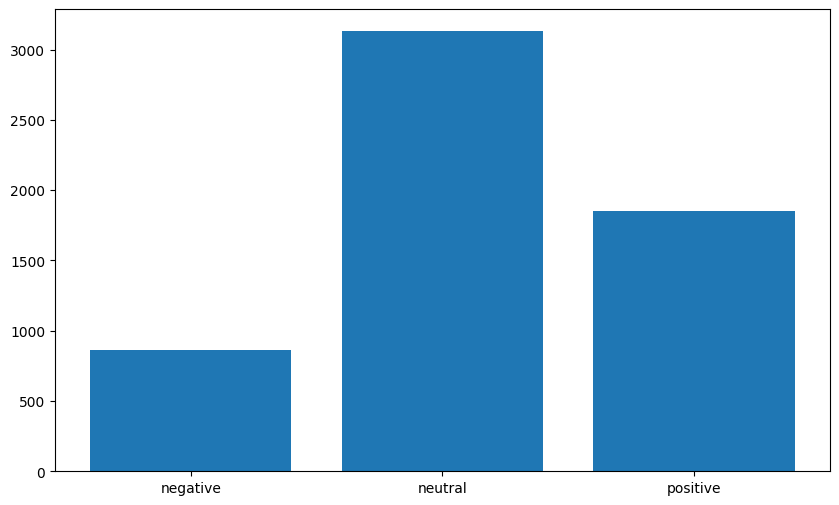

In [53]:
s_counts = df.groupby('Sentiment')['Sentence'].count()
plt.figure(figsize=(10,6))
plt.bar(s_counts.index, s_counts.values)

# Resampling

In [54]:
from sklearn.utils import resample

In [55]:
neg = df[(df['Sentiment'] == 'negative')]
neu = df[(df['Sentiment'] == 'neutral')]
pos = df[(df['Sentiment'] == 'positive')]
lists = [neg, neu, pos]

In [56]:
resampled = []
num = 2500

for sent in lists:
    resampled_sent = resample(sent, n_samples=num, random_state=42)
    resampled.append(resampled_sent)
    
df = pd.concat(resampled)
df.head()

,Sentence,Sentiment
742,"The currency effect had a 3.0 pct , or 20 mln ...",negative
3015,$MFLX up pre mkt. Looks like GAP has been fil...,negative
1898,"However , the growth margin slowed down due to...",negative
777,It's a bad idea to make 5 min predictions base...,negative
472,"Key price to watch in $NFLX, off the previous ...",negative


<BarContainer object of 3 artists>

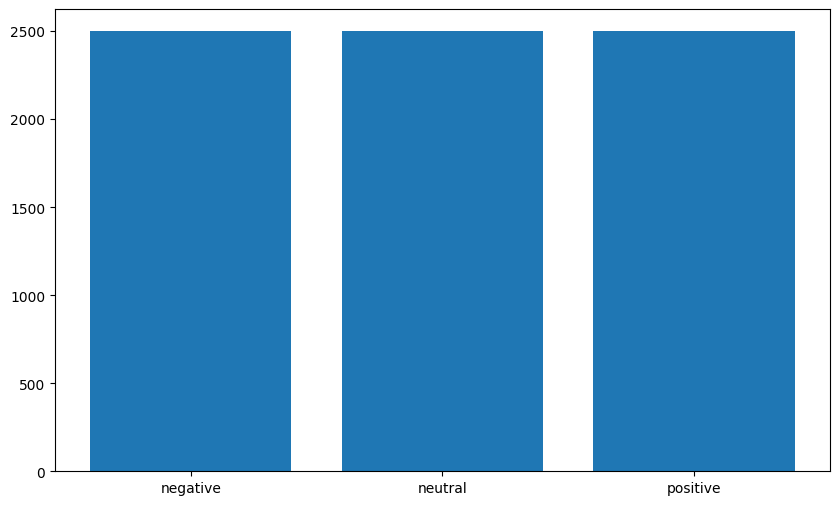

In [57]:
s_counts = df.groupby('Sentiment')['Sentence'].count()
plt.figure(figsize=(10,6))
plt.bar(s_counts.index, s_counts.values)

# Language Processing

In [58]:
import nltk

In [59]:
def special_char_removal(text):
    string = ''
    for char in text:
        if(char.isalnum() or char.isspace()):
            string += char
    return string

In [60]:
def tolower(text):
    return text.lower()

In [61]:
def stopwords_removal(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return ' '.join(filtered)

In [62]:
print(f"Sample before:\n{df['Sentence'][0]}")

df['Sentence'] = df['Sentence'].apply(special_char_removal)
df['Sentence'] = df['Sentence'].apply(tolower)
df['Sentence'] = df['Sentence'].apply(stopwords_removal)

print(f"Sample after:\n{df['Sentence'][0]}")

Sample before:
0    The GeoSolutions technology will leverage Bene...
0    The GeoSolutions technology will leverage Bene...
Name: Sentence, dtype: object
Sample after:
0    geosolutions technology leverage benefon gps s...
0    geosolutions technology leverage benefon gps s...
Name: Sentence, dtype: object


# Encoding

In [63]:
from sklearn.preprocessing import LabelEncoder

In [64]:
encoder = LabelEncoder()
df['Sentiment'] = encoder.fit_transform(df['Sentiment'])
df.head()

,Sentence,Sentiment
742,currency effect 30 pct 20 mln euro 313 mln neg...,0
3015,mflx pre mkt looks like gap filledlookin 4 sho...,0
1898,however growth margin slowed due financial crisis,0
777,bad idea make 5 min predictions based faith rt...,0
472,key price watch nflx previous double top rejec...,0


# Tokenize

In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [66]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Sentence'])
seq = tokenizer.texts_to_sequences(df['Sentence'])
w_index = tokenizer.word_index

In [67]:
len(w_index)

9977

(array([5.840e+02, 2.934e+03, 1.904e+03, 1.177e+03, 4.250e+02, 3.310e+02,
        1.360e+02, 7.000e+00, 0.000e+00, 2.000e+00]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

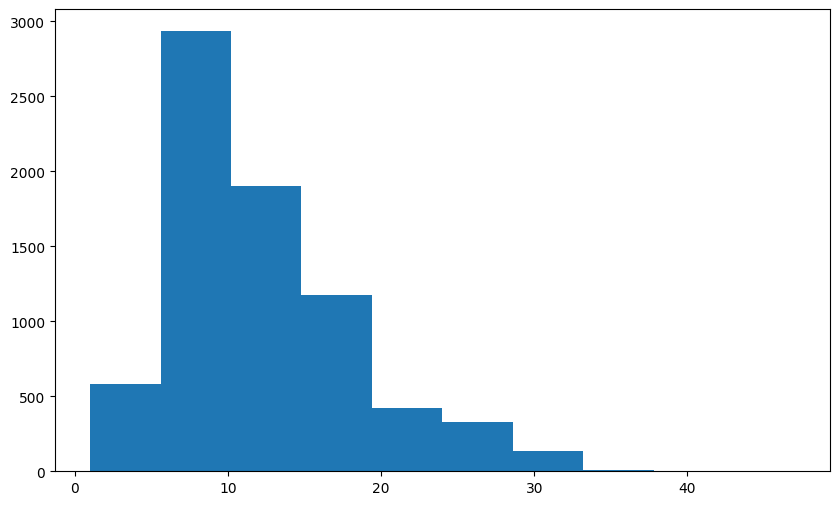

In [68]:
seq_len = [len(s) for s in seq]
plt.figure(figsize=(10,6))
plt.hist(seq_len)

In [69]:
padded = pad_sequences(seq, maxlen=40)

# Train Validate Test Split

In [70]:
from sklearn.model_selection import  train_test_split

In [71]:
x_train, x_temp, y_train, y_temp = train_test_split(padded, df['Sentiment'], test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Model

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAvgPool1D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [73]:
model = Sequential([
    Embedding(input_dim=len(w_index)+1, output_dim=128),
    GlobalAvgPool1D(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

In [74]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [75]:
epoch = 10
batch = 128

stopping = EarlyStopping(monitor='val_loss', patience = 3)

hist = model.fit(x_train, y_train, epochs=epoch, batch_size=batch, validation_data=(x_val, y_val), callbacks=[stopping])

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3395 - loss: 1.0987 - val_accuracy: 0.3453 - val_loss: 1.0948
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4010 - loss: 1.0839 - val_accuracy: 0.5547 - val_loss: 0.9636
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5761 - loss: 0.9090 - val_accuracy: 0.7907 - val_loss: 0.6436
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8144 - loss: 0.5057 - val_accuracy: 0.8253 - val_loss: 0.4628
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8763 - loss: 0.3246 - val_accuracy: 0.8253 - val_loss: 0.4467
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9031 - loss: 0.2525 - val_accuracy: 0.8373 - val_loss: 0.4440
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9281 - loss: 0.1763 - val_accuracy: 0.8507 - val_loss: 0.4110
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9415 - loss: 0.1547 - val_accuracy: 0.8493 - v

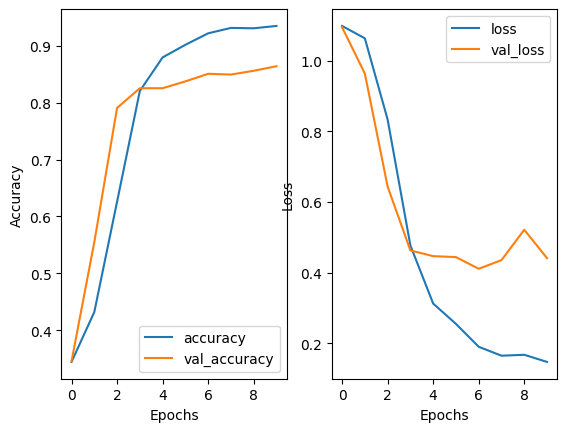

In [78]:
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

plt.show()

In [76]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Loss = {loss}\nAccuracy = {accuracy}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8349 - loss: 0.5358 
Loss = 0.5607848763465881
Accuracy = 0.8293333053588867


In [81]:
y_pred = model.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)

for i in range(20):
    print(f'Sentence {i}:\nPred : {y_test.iloc[i]}\nActual : {y_pred_class[i]}\n')

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Sentence 0:
Pred : 1
Actual : 1

Sentence 1:
Pred : 1
Actual : 1

Sentence 2:
Pred : 1
Actual : 1

Sentence 3:
Pred : 1
Actual : 0

Sentence 4:
Pred : 2
Actual : 2

Sentence 5:
Pred : 0
Actual : 0

Sentence 6:
Pred : 2
Actual : 2

Sentence 7:
Pred : 2
Actual : 2

Sentence 8:
Pred : 2
Actual : 2

Sentence 9:
Pred : 0
Actual : 0

Sentence 10:
Pred : 2
Actual : 2

Sentence 11:
Pred : 0
Actual : 0

Sentence 12:
Pred : 2
Actual : 1

Sentence 13:
Pred : 0
Actual : 0

Sentence 14:
Pred : 1
Actual : 1

Sentence 15:
Pred : 1
Actual : 1

Sentence 16:
Pred : 2
Actual : 2

Sentence 17:
Pred : 1
Actual : 0

Sentence 18:
Pred : 0
Actual : 0

Sentence 19:
Pred : 0
Actual : 0

